In [1]:
# !pip install nltk    
# !pip install emoji        
# !pip install autocorrec\t    
# !pip install xgboost
# !pip install -U spacy

In [2]:
# nltk.download('punkt')  # for using word_tokenizer
# nltk.download('wordnet')  # for using Lemmatizer
# nltk.download('averaged_perceptron_tagger') # for language processing i.e tagging words with their parts of speech (POS)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import spacy
import nltk
import re   # regular expression
import string
import emoji
from autocorrect import Speller   # for correcting spelling
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize    # for tokenizing string into words
from nltk.stem import WordNetLemmatizer    # for lemmatizing words
from nltk.tag import pos_tag # for tagging words with their parts of speech (POS)

In [2]:
from sklearn.preprocessing import LabelEncoder

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,chi2, mutual_info_classif,f_classif

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import xgboost
from xgboost import XGBClassifier

In [6]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [7]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score

In [8]:
df_train = pd.read_csv('data/project_training_data_with_class_labels.csv',dtype=str,delimiter=',',quoting=3)

In [9]:
df_train.shape

(808661, 4)

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808661 entries, 0 to 808660
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ID               808661 non-null  object
 1   Comments         808623 non-null  object
 2   Parent Comments  808661 non-null  object
 3    Class Labels    808661 non-null  object
dtypes: object(4)
memory usage: 24.7+ MB


In [11]:
# to check for null value
df_train.isna().sum()

ID                  0
Comments           38
Parent Comments     0
 Class Labels       0
dtype: int64

In [12]:
df_train.columns

Index(['ID', 'Comments', 'Parent Comments', ' Class Labels '], dtype='object')

In [13]:
df_train.rename(columns={' Class Labels ' : 'Class Labels'},inplace=True) # changing col name
df_train.columns

Index(['ID', 'Comments', 'Parent Comments', 'Class Labels'], dtype='object')

In [14]:
# remove data points whose class labels are not present
# df_train.dropna(subset=['Comments'], inplace=True)      # then dropped that rows with no value

In [15]:
df_train= df_train.replace(to_replace = np.nan, value = '', regex = True)

In [16]:
# to check for null value
df_train.isna().sum()

ID                 0
Comments           0
Parent Comments    0
Class Labels       0
dtype: int64

In [17]:
# Inserting the column before Class Labels col.
df_train.insert(loc = 3,
        column = 'Text',
        value = df_train['Parent Comments'] + " " +df_train['Comments'])

df_train.head()

,ID,Comments,Parent Comments,Text,Class Labels
0,ocxtitan,Central Illinois,Jesus; where do you live?,Jesus; where do you live? Central Illinois,non-sarcastic
1,LeChuckly,To think - CNN used to be the acronym synonymo...,Even The CNN Staff Is Sick Of The Wall-To-Wall...,Even The CNN Staff Is Sick Of The Wall-To-Wall...,non-sarcastic
2,throwitskrub8,But then again; you have to consider that all ...,agree to that part.It can also mean that gujra...,agree to that part.It can also mean that gujra...,non-sarcastic
3,fresherthanyouuu,ughhhhh,If a guy told you he doesn't use social media ...,If a guy told you he doesn't use social media ...,non-sarcastic
4,_kushagra,I should've put the,No; it's just a programming bug. After all; th...,No; it's just a programming bug. After all; th...,sarcastic


In [18]:
df_train.shape

(808661, 5)

In [19]:
# # we are combining Parent Comment and Comment cols. into one cols.
# df_train['Text'] = df_train['Parent Comments'] + " " +df_train['Comments']
# df_train.head()

In [20]:
# to check for null value
df_train.isnull().sum()

ID                 0
Comments           0
Parent Comments    0
Text               0
Class Labels       0
dtype: int64

In [21]:
# # we know that adding any thing with nan value gives nan. so in Text col having nan value we replace 
# # one time with comment col. value where value of parent comment col is nan and other with parent comment where
# # comment col. is empty.

# # fill the rows of Col. Text having no values with that of col. Parent Comments where Comment col. is empty
# df_train['Text'][df_train['Comments'].isnull()] = df_train['Parent Comments'][df_train['Comments'].isnull()]

# # fill the rows of Col. Text having no values with that of col. Comments where Parent Comment col. is empty
# df_train['Text'][df_train['Parent Comments'].isnull()] = df_train['Comments'][df_train['Parent Comments'].isnull()]

In [22]:
# # to check for null value
# df_train.isnull().sum()

Since here there is issue with the format of some rows. So we are manually correcting them.

In [23]:
df_test = pd.read_csv('data/project_test_data.csv',dtype=str,delimiter=',',quoting=3)
df_test.head()

,ID,Comments,Parent Comments
0,theyoungthaddeus,"No one ""needs"" an assault foam dart blaster",Your son has to register those at the county j...
1,Just_an_asian_here,Cause all attractive women are uninteresting a...,Likely due to creative and interesting content.
2,Foxprowl,Poser.,Jon Stewart is going to HBO
3,kd7rzv,Won't be long and Anet will start banning peop...,This post looks like bullshit market manipulat...
4,Ellefied,There goes my hope that Kubo does a Kojima as ...,Plus the Japanese typically do not talk shit w...


In [24]:
df_test.shape

(202166, 3)

In [25]:
# to check for null value
df_test.isnull().sum()

ID                   0
Comments            15
Parent Comments      0
dtype: int64

In [26]:
df_test= df_test.replace(to_replace = np.nan, value = '', regex = True)

In [27]:
# to check for null value
df_test.isnull().sum()

ID                  0
Comments            0
Parent Comments     0
dtype: int64

In [28]:
df_test.columns

Index(['ID', 'Comments', 'Parent Comments '], dtype='object')

In [29]:
df_test.rename(columns={'Parent Comments ': 'Parent Comments'},inplace = True)

In [30]:
df_test.columns

Index(['ID', 'Comments', 'Parent Comments'], dtype='object')

In [31]:
# we are combining Parent Comment and Comment cols. into one cols.
df_test['Text'] = df_test['Parent Comments'] + " " +df_test['Comments']
df_test.head()

,ID,Comments,Parent Comments,Text
0,theyoungthaddeus,"No one ""needs"" an assault foam dart blaster",Your son has to register those at the county j...,Your son has to register those at the county j...
1,Just_an_asian_here,Cause all attractive women are uninteresting a...,Likely due to creative and interesting content.,Likely due to creative and interesting content...
2,Foxprowl,Poser.,Jon Stewart is going to HBO,Jon Stewart is going to HBO Poser.
3,kd7rzv,Won't be long and Anet will start banning peop...,This post looks like bullshit market manipulat...,This post looks like bullshit market manipulat...
4,Ellefied,There goes my hope that Kubo does a Kojima as ...,Plus the Japanese typically do not talk shit w...,Plus the Japanese typically do not talk shit w...


<AxesSubplot: >

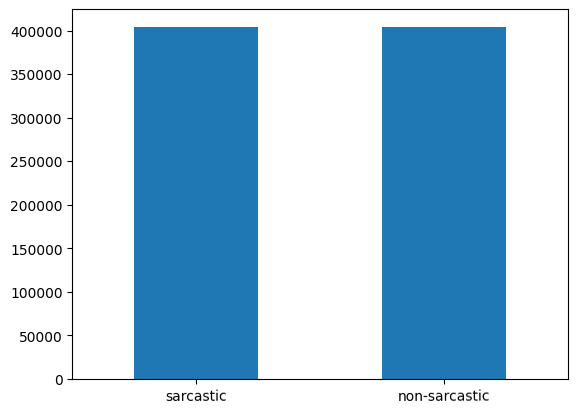

In [32]:
df_train['Class Labels'].value_counts().plot(kind = 'bar',rot = .3)

In [33]:
# english Stopwords
stopwords_list = stopwords.words('english')

In [34]:
# used this dictionary for expanding conracted words. this is taken from Github
CONTRACTIONS = {
    "I'm": "I am",
    "I'm'a": "I am about to",
    "I'm'o": "I am going to",
    "I've": "I have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'd": "I would",
    "I'd've": "I would have",
    "Whatcha": "What are you",
    "amn't": "am not",
    "ain't": "are not",
    "aren't": "are not",
    "'cause": "because",
    "can't": "cannot",
    "can't've": "cannot have",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "daren't": "dare not",
    "daresn't": "dare not",
    "dasn't": "dare not",
    "didn't": "did not",
    "didn’t": "did not",
    "don't": "do not",
    "don’t": "do not",
    "doesn't": "does not",
    "e'er": "ever",
    "everyone's": "everyone is",
    "finna": "fixing to",
    "gimme": "give me",
    "gon't": "go not",
    "gonna": "going to",
    "gotta": "got to",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he've": "he have",
    "he's": "he is",
    "he'll": "he will",
    "he'll've": "he will have",
    "he'd": "he would",
    "he'd've": "he would have",
    "here's": "here is",
    "how're": "how are",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how's": "how is",
    "how'll": "how will",
    "isn't": "is not",
    "it's": "it is",
    "'tis": "it is",
    "'twas": "it was",
    "it'll": "it will",
    "it'll've": "it will have",
    "it'd": "it would",
    "it'd've": "it would have",
    "kinda": "kind of",
    "let's": "let us",
    "luv": "love",
    "ma'am": "madam",
    "may've": "may have",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "ne'er": "never",
    "o'": "of",
    "o'clock": "of the clock",
    "ol'": "old",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "o'er": "over",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shalln't": "shall not",
    "shan't've": "shall not have",
    "she's": "she is",
    "she'll": "she will",
    "she'd": "she would",
    "she'd've": "she would have",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "somebody's": "somebody is",
    "someone's": "someone is",
    "something's": "something is",
    "sux": "sucks",
    "that're": "that are",
    "that's": "that is",
    "that'll": "that will",
    "that'd": "that would",
    "that'd've": "that would have",
    "em": "them",
    "there're": "there are",
    "there's": "there is",
    "there'll": "there will",
    "there'd": "there would",
    "there'd've": "there would have",
    "these're": "these are",
    "they're": "they are",
    "they've": "they have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they'd": "they would",
    "they'd've": "they would have",
    "this's": "this is",
    "those're": "those are",
    "to've": "to have",
    "wanna": "want to",
    "wasn't": "was not",
    "we're": "we are",
    "we've": "we have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we'd": "we would",
    "we'd've": "we would have",
    "weren't": "were not",
    "what're": "what are",
    "what'd": "what did",
    "what've": "what have",
    "what's": "what is",
    "what'll": "what will",
    "what'll've": "what will have",
    "when've": "when have",
    "when's": "when is",
    "where're": "where are",
    "where'd": "where did",
    "where've": "where have",
    "where's": "where is",
    "which's": "which is",
    "who're": "who are",
    "who've": "who have",
    "who's": "who is",
    "who'll": "who will",
    "who'll've": "who will have",
    "who'd": "who would",
    "who'd've": "who would have",
    "why're": "why are",
    "why'd": "why did",
    "why've": "why have",
    "why's": "why is",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "you're": "you are",
    "you've": "you have",
    "you'll've": "you shall have",
    "you'll": "you will",
    "you'd": "you would",
    "you'd've": "you would have"
 }

In [35]:
#I created a dictionary for emoticons
EMOTICONS = {
    u":‑)":"Happy",
    u":-))":"Very Happy",
    u":-)))":"Very very Happy",
    u":)":"Happy",
    u":))":"Very Happy",
    u":)))":"Very very Happy",
    u":-]":"Happy",
    u":]":"Happy",
    u":-3":"Happy",
    u":3":"Happy",
    u":->":"Happy",
    u":>":"Happy",
    u"8-)":"Happy",
    u":o)":"Happy",
    u":-}":"Happy",
    u":}":"Happy",
    u":-)":"Happy",
    u":c)":"Happy",
    u":^)":"Happy",
    u"=]":"Happy",
    u"=)":"Happy",
    u":‑D":"Laughing",
    u":D":"Laughing",
    u"8‑D":"Laughing",
    u"8D":"Laughing",
    u"X‑D":"Laughing",
    u"XD":"Laughing",
    u"=D":"Laughing",
    u"=3":"Laughing",
    u"B^D":"Laughing",
    u":-))":"Very happy",
    u"<3":"love",
    u":-(":"sad",
    u":‑(":"sad",
    u":(":"sad",
    u":‑c":"sad",
    u":c":"sad",
    u":‑<":"sad",
    u":<":"sad",
    u":‑[":"sad",
    u":[":"sad",
    u":-||":"sad",
    u">:[":"sad",
    u":{":"sad",
    u":@":"sad",
    u">:(":"sad",
    u":'‑(":"Crying",
    u":'(":"Crying",
    u":'‑)":"Tears of happiness",
    u":')":"Tears of happiness",
    u"D‑':":"sad",
    u"D:<":"sad",
    u"D:":"sad",
    u"D8":"very sad",
    u"D;":"very sad",
    u"D=":"very sad",
    u"DX":"very sad",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Sad",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-*":"Kiss",
    u":*":"Kiss",
    u":X":"Kiss",
    u";‑)":"Wink",
    u";)":"Wink",
    u"*-)":"Wink",
    u"*)":"Wink",
    u";‑]":"Wink",
    u";]":"Wink",
    u";^)":"Wink",
    u":‑,":"Wink",
    u";D":"Wink",
    u":‑P":"fun",
    u":P":"fun",
    u"X‑P":"fun",
    u"XP":"fun",
    u":‑Þ":"fun",
    u":Þ":"fun",
    u":b":"fun",
    u"d:":"fun",
    u"=p":"fun",
    u">:P":"fun",
    u":‑/":"annoyed",
    u":/":"annoyed",
    u":-[.]":"annoyed",
    u">:[(\)]":"annoyed",
    u">:/":"annoyed",
    u":[(\)]":"annoyed",
    u"=/":"annoyed",
    u"=[(\)]":"annoyed",
    u":L":"annoyed",
    u"=L":"annoyed",
    u":S":"annoyed",
    u":‑|":"indecision",
    u":|":"indecision",
    u":$":"Embarrassed",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑)":"Angel",
    u"O:)":"Angel",
    u"0:‑3":"Angel",
    u"0:3":"Angel",
    u"0:‑)":"Angel",
    u"0:)":"Angel",
    u":‑b":"fun",
    u"0;^)":"Angel",
    u">:‑)":"devilish",
    u">:)":"devilish",
    u"}:‑)":"devilish",
    u"}:)":"devilish",
    u"3:‑)":"devilish",
    u"3:)":"devilish",
    u">;)":"devilish",
    u"|;‑)":"Cool",
    u"|‑O":"Bored",
    u":‑J":"Tongue in cheek",
    u"#‑)":"Party all night",
    u"%‑)":"confused",
    u"%)":"confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑|":"silent",
    u"(>_<)":"Troubled",
    u"(>_<)>":"Troubled",
    u"(';')":"Baby",
    u"(^^>``":"Nervous",
    u"(^_^;)":"Troubled",
    u"(-_-;)":"Nervous",
    u"(~_~;) (・.・;)":"Shy",
    u"(-_-)zzz":"Sleeping",
    u"(^_-)":"Wink",
    u"((+_+))":"Confused",
    u"(+o+)":"Confused",
    u"(o|o)":"Ultraman",
    u"^_^":"happy",
    u"(^_^)/":"happy",
    u"(^O^)／":"happy",
    u"(^o^)／":"happy",
    u"(__)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_(._.)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<(_ _)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m(__)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m(__)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m(_ _)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"('_')":"Sad",
    u"(/_;)":"Sad",
    u"(T_T) (;_;)":"Sad",
    u"(;_;":"Sad",
    u"(;_:)":"Sad",
    u"(;O;)":"Sad",
    u"(:_;)":"Sad",
    u"(ToT)":"Sad",
    u";_;":"Sad",
    u";-;":"Sad",
    u";n;":"Sad",
    u";;":"Sad",
    u"Q.Q":"Sad",
    u"T.T":"Sad",
    u"QQ":"Sad",
    u"Q_Q":"Sad",
    u"(-.-)":"Shame",
    u"(-_-)":"Shame",
    u"(一一)":"Shame",
    u"(；一_一)":"Shame",
    u"(=_=)":"Tired",
    u"(=^·^=)":"cat",
    u"(=^··^=)":"cat",
    u"=_^= ":"cat",
    u"(..)":"Looking down",
    u"(._.)":"Looking down",
    u"^m^":"Giggling",
    u"(・・?":"Confusion",
    u"(?_?)":"Confusion",
    u">^_^<":"Normal Laugh",
    u"<^!^>":"Normal Laugh",
    u"^/^":"Normal Laugh",
    u"（*^_^*）" :"Normal Laugh",
    u"(^<^) (^.^)":"Normal Laugh",
    u"(^^)":"Normal Laugh",
    u"(^.^)":"Normal Laugh",
    u"(^_^.)":"Normal Laugh",
    u"(^_^)":"Normal Laugh",
    u"(^^)":"Normal Laugh",
    u"(^J^)":"Normal Laugh",
    u"(*^.^*)":"Normal Laugh",
    u"(^—^）":"Normal Laugh",
    u"(#^.^#)":"Normal Laugh",
    u"（^—^）":"Waving",
    u"(;_;)/~~~":"Waving",
    u"(^.^)/~~~":"Waving",
    u"(-_-)/~~~ ($··)/~~~":"Waving",
    u"(T_T)/~~~":"Waving",
    u"(ToT)/~~~":"Waving",
    u"(*^0^*)":"Excited",
    u"(*_*)":"Excited",
    u"(*_*;":"Excited",
    u"(+_+) (@_@)":"Excited",
    u"(*^^)v":"Cheerful",
    u"(^_^)v":"Cheerful",
    u"((d[-_-]b))":"Headphones,Listening to music",
    u'(-"-)':"Worried",
    u"(ーー;)":"Worried",
    u"(^0_0^)":"Eyeglasses",
    u"(＾ｖ＾)":"Happy",
    u"(＾ｕ＾)":"Happy",
    u"(^)o(^)":"Happy",
    u"(^O^)":"Happy",
    u"(^o^)":"Happy",
    u")^o^(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o.O":"Surpised",
    u"(o.o)":"Surprised",
    u"oO":"Surprised",
    u"(*￣m￣)":"Dissatisfied",
    u"(‘A`)":"Deflated"

}

In [155]:
def preprocess_text(tweet):
    nan_tweet = 'NaN'  
    # this code is to short unnecessary sentence, bec. some rows has unnecessary long repeated characters
    # like 'HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH'
    # we manually decide len = 10 any with len >10 is discarded
        # convert all text lowercase
    tweet = tweet.lower() 
    tweet = tweet.split()
    tw = []
    for t in tweet:
        # removing digits only
        try:
            int(t)
            continue
        except:
            pass
        if len(t)<=20:
            if len(set(t))<=1:
                continue
            tw.append(t)
    tweet = ' '.join(tw)   
    # remove any urls
    tweet = re.sub(r"www\S+|http\S+|", "",tweet, flags = re.MULTILINE)
    # remove square bracket including its content if
    tweet = re.sub(r'\[|\]'," ",tweet)
    # to remove new line character
    tweet = re.sub(r'\n', " ", tweet)
    # remove user @ references and '#' from tweet
    tweet = re.sub(r"\@\w+|\#", "",tweet)
    # replace emojis with its meaning
    tweet = (emoji.demojize(tweet, delimiters=(" ", ""))).replace('_',' ')
    # expand contractions
    splitted_string = tweet.split()
    for index, text in enumerate(splitted_string):
        if text in CONTRACTIONS.keys():
            splitted_string[index] = CONTRACTIONS[text]
    tweet = ' '.join(splitted_string)
    # replace emoticons with its meaning
    splitted_tweet = tweet.split()
    for index, word in enumerate(splitted_tweet):
        if word in EMOTICONS.keys():
            splitted_tweet[index] = EMOTICONS[word]
    tweet = ' '.join(splitted_tweet)
    # remove tags
    tweet = re.sub(re.compile('<.*?>'), '', tweet)
    # remove punctuations
    tweet = tweet.translate(str.maketrans("","",string.punctuation))
    # remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [word for word in tweet_tokens if word not in stopwords_list]
    # spelling correction
    correct_words = []
    # initialize Speller object for english language
    spell_corrector = Speller(lang='en')
    for word in filtered_words:
        correct_word = spell_corrector(word)
        correct_words.append(correct_word)
    # lemmatizing
    wnl = WordNetLemmatizer()
    lemma_words = []
    for word, tag in pos_tag(correct_words):      # Part-of-speech constants for ADJ,VERB,ADV = 'a', 'r', 'v'
        if tag.startswith('JJ'):      # for adjectives
            lemma_word = wnl.lemmatize(word, pos='a')
            lemma_words.append(lemma_word)
        elif tag.startswith('VB'):   # for verbs
            lemma_word = wnl.lemmatize(word, pos='v')
            lemma_words.append(lemma_word)
        elif tag.startswith('RB'):   # for adverbs
            lemma_word = wnl.lemmatize(word, pos='r')
            lemma_words.append(lemma_word)
        else:
            lemma_word = word
            lemma_words.append(lemma_word)
        
    tweet = " ".join(lemma_words)
    if len(tweet) == 0:   # if after pre-processing sent. has no letter
        tweet = nan_tweet
    return tweet

In [ ]:
pre

In [166]:

text = 'aaaaaaaaawesome'
preprocess_text(text)
# len('HAHAHAHAHAHgoodaaaaa')

'aaaaaaaaawesome'

In [ ]:
# on train data
# applying preprocess_tweet_text() func. on each tweet in Comments and Parent Comments coloumn in dataframe
# df_train['Comments'] = df_train['Comments'].apply(preprocess_tweet_text)
# df_train['Parent Comments'] = df_train['Parent Comments'].apply(preprocess_tweet_text)
# df_train

In [33]:
# 24000:250000 error somewhere
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True,nb_workers=64)

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [35]:
t = time.time()
xx = df_train['Text'].parallel_apply(preprocess_text) 
df_train.insert(loc = 4,
        column = 'Pre Processed Text',
        value = xx)
# saving
df_train.to_csv('processed_train.csv',index=False) # on train data, 
tt = time.time() - t
print(f'{tt} sec')

2677.4445066452026 sec


In [36]:
t = time.time()
xtt = df_test['Text'].parallel_apply(preprocess_text) # on test data
df_test.insert(loc = 4,
        column = 'Pre Processed Text',
        value = xtt)
df_test.to_csv('processed_test.csv',index=False)
tt = time.time() - t
print(f'{tt} sec')

725.7949583530426 sec


# Reading the pre-processed csv

In [8]:
df_prepro_train = pd.read_csv('processed_train.csv')

In [9]:
print(df_prepro_train.shape)
df_prepro_train.head()

(808661, 6)


,ID,Comments,Parent Comments,Text,Pre Processed Text,Class Labels
0,ocxtitan,Central Illinois,Jesus; where do you live?,Jesus; where do you live? Central Illinois,jesus live central illinois,non-sarcastic
1,LeChuckly,To think - CNN used to be the acronym synonymo...,Even The CNN Staff Is Sick Of The Wall-To-Wall...,Even The CNN Staff Is Sick Of The Wall-To-Wall...,even cnn staff sick walltowall trump coverage ...,non-sarcastic
2,throwitskrub8,But then again; you have to consider that all ...,agree to that part.It can also mean that gujra...,agree to that part.It can also mean that gujra...,agree parti also mean gujarat husbands good su...,non-sarcastic
3,fresherthanyouuu,ughhhhh,If a guy told you he doesn't use social media ...,If a guy told you he doesn't use social media ...,guy tell use social media go head ughhhhh,non-sarcastic
4,_kushagra,I should've put the,No; it's just a programming bug. After all; th...,No; it's just a programming bug. After all; th...,program bug android app music service still be...,sarcastic


In [10]:
df_prepro_train.isna().sum()

ID                     0
Comments              38
Parent Comments        0
Text                   0
Pre Processed Text     0
Class Labels           0
dtype: int64

In [11]:
# test
df_prepro_test = pd.read_csv('processed_test.csv')
print(df_prepro_test.shape)
df_prepro_test.head()

(202166, 5)


,ID,Comments,Parent Comments,Text,Pre Processed Text
0,theyoungthaddeus,"No one ""needs"" an assault foam dart blaster",Your son has to register those at the county j...,Your son has to register those at the county j...,son register county jungle gym mags hold ounce...
1,Just_an_asian_here,Cause all attractive women are uninteresting a...,Likely due to creative and interesting content.,Likely due to creative and interesting content...,likely due creative interesting content cause ...
2,Foxprowl,Poser.,Jon Stewart is going to HBO,Jon Stewart is going to HBO Poser.,jon stewart go hbo power
3,kd7rzv,Won't be long and Anet will start banning peop...,This post looks like bullshit market manipulat...,This post looks like bullshit market manipulat...,post looks like bullshit market manipulation w...
4,Ellefied,There goes my hope that Kubo does a Kojima as ...,Plus the Japanese typically do not talk shit w...,Plus the Japanese typically do not talk shit w...,plus japanese typically talk shit come busines...


In [12]:
df_prepro_test.isna().sum()

ID                     0
Comments              15
Parent Comments        0
Text                   0
Pre Processed Text     0
dtype: int64

In [14]:
# X_tst.isna().sum() # problem: If the sentence is madeup of only stopwords, numbers etc., the sentence after preprocess becomes empty results in NaN
# # fix, after preprocess check sentence length if its 0, return the orig sentence without preprocess. else preprocess. 

In [15]:
# # df[['Comments','Parent Comments']][df['Comments'].isnull()]
# X_tst[X_tst['Text'].isnull()]

In [13]:
# Train data
X = df_prepro_train['Pre Processed Text']
y_trn = df_prepro_train['Class Labels']

# Test data
X_test = df_prepro_test['Pre Processed Text']

In [14]:
# converting Labels coloumn into numerical form of train data
encoder = LabelEncoder()
y = encoder.fit_transform(y_trn)

In [15]:
encoder.classes_

array(['non-sarcastic', 'sarcastic'], dtype=object)

In [16]:
np.unique(y)

array([0, 1])

In [17]:
# train validation split of data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=3,stratify=y)
X_train.shape,X_valid.shape

((646928,), (161733,))

# BoW

In [68]:
import re
ans = ""
for a in re.findall('[A-Z][^A-Z]*',"HAHAHAHAHA HA"):
   ans+=a.strip()+' '

ans

'H A H A H A H A H A H A '

In [115]:
def getCounts(strng):
    if not strng:
        return [], 0
    counts = {}
    current = strng[0]
    for c in strng:
        if c in counts.keys():
            if current==c:
                counts[c] += 1
        else:
            current = c
            counts[c] = 1
    return counts.keys(), min(counts.values())

result = ''
counts=getCounts('BWAHAHAHAHAHAHAHAHAHHHAAHAHAHAHAHHAHAHAHAHAHAHHAHAAHAHAHAHAHAH')
for i in range(counts[1]):
    result += ''.join(counts[0])
result

# result = 'aprilaprilapril'

'BWAH'

In [113]:
s = nltk.stem.Cistem()
s.stem('gooood')

'gooood'

In [114]:
import re

word = 'HAB'
text = 'BWAHAHAHAHAHAHAHAHAHHHAAHAHAHAHAHHAHAHAHAHAHAHHAHAAHAHAHAHAHAH'

regex = "".join(f"({c}+)" for c in word)
match = re.match(regex, text)
# print(match)

if match:
    # Find the lowest amount of character repeats
    lowest_amount = min(len(g) for g in match.groups())
    print(word )

In [81]:
def BinaryToDecimal(binary):
        
    binary1 = binary
    decimal, i, n = 0, 0, 0
    while(binary != 0):
        dec = binary % 10
        decimal = decimal + dec * pow(2, i)
        binary = binary//10
        i += 1
    return (decimal)   

str_data =' '
bin_data ='0100000101101110001000000110000101100100011101100110010101110010011101000110100101110011011001010110110101100101011011100111010000111111001000000010000001010011011011110110111000100000011011110110011000100000011000010010000001100010011010010111010001100011011010000010000000101000010010010010000001110000011100100110111101100010011000010110110001111001001000000110001001110101011101000110001101101000011001010111001001100101011001000010000001110100011010000110000101110100001011000010000001100010011101010111010000100000011010010111010001110011001000000110001001100101011001010110111000100000011000010010000001110111011010000110100101101100011001010010110000100000011000110111010101110100001000000110110101100101001000000111001101101111011011010110010100100000011100110110110001100001011000110110101100101001'
# slicing the input and converting it
# in decimal and then converting it in string
for i in range(0, len(bin_data), 7):
     
    # slicing the bin_data from index range [0, 6]
    # and storing it as integer in temp_data
    temp_data = int(bin_data[i:i + 7])
      
    # passing temp_data in BinarytoDecimal() function
    # to get decimal value of corresponding temp_data
    decimal_data = BinaryToDecimal(temp_data)
      
    # Decoding the decimal value returned by
    # BinarytoDecimal() function, using chr()
    # function which return the string corresponding
    # character for given ASCII value, and store it
    # in str_data
    str_data = str_data + chr(decimal_data)
  
# printing the result
print("The Binary value after string conversion is:",
       str_data)

#L@b2Y-b@w4-F)0@c:]k@s7[,RMXa1ZeaDu  [Dle9


In [60]:
# X1 = np.hstack(X.values) # since Count vec takes only list of items
# X_tst1 = np.hstack(X_tst.values)
CV = CountVectorizer(ngram_range=(1,1),max_features=100000)
X_train_bow = sp.csr_matrix(CV.fit_transform(X_train))

In [62]:
CV.get_feature_names_out()[0:1000]

array(['0000', '00000011', '00001001', '00001011', '0001', '00010001',
       '00010101', '00011001', '00011011', '00011101', '00100000',
       '00100011', '00101001', '00101100', '00101110', '0011', '00110001',
       '00110011', '00110101', '00111001', '0023', '0030', '0100',
       '01000001',
       '010000010110111000100000011000010110010001110110011001010111001001110100011010010111001101100101011011010110010101101110011101000011111100100000001000000101001101101111011011100010000001101111011001100010000001100001001000000110001001101001011101000110001101101000001000000010100001001001001000000111000001110010011011110110001001100001011011000111100100100000011000100111010101110100011000110110100001100101011100100110010101100100001000000111010001101000011000010111010000101100001000000110001001110101011101000010000001101001011101000111001100100000011000100110010101100101011011100010000001100001001000000111011101101000011010010110110001100101001011000010000001100011011101010111010000100

In [18]:
import scipy.sparse as sp

In [21]:
import multiprocessing
import pandas as pd
import numpy as np
from multiprocessing import Pool


num_cores = multiprocessing.cpu_count()
num_partitions = num_cores-2 # I like to leave some cores for other
#processes
print(num_partitions)


def parallelize_dataframe(df, func):
    a = np.array_split(df, num_partitions)
    del df
    pool = Pool(num_cores)
    #df = pd.concat(pool.map(func, [a,b,c,d,e]))
    # func = func(cv=cv)
    df = sp.vstack(pool.map(func,a), format='csr')
    pool.close()
    pool.join()
    return df

def test_func2(data,cv=CV,train=False):
    X_bow = cv.transform(data)
    return X_bow

62


NameError: name 'CV' is not defined

In [19]:
X_train_bow.shape

NameError: name 'X_train_bow' is not defined

In [23]:
X_train_bow.__sizeof__()

32

In [87]:
# CV.get_feature_names()

In [119]:
X_valid_bow = parallelize_dataframe(X_valid, test_func2)

In [19]:
import joblib
# joblib.dump(X_valid_bow.tocsr(), 'X_valid_bow.joblib')
X_train_bow = joblib.load('X_train_bow.joblib', mmap_mode='c')
X_valid_bow = joblib.load('X_valid_bow.joblib', mmap_mode='c')

In [91]:
# del X_train_bow

In [120]:
# x_csr = joblib.load('X_train_bow.joblib', mmap_mode='c')
x_csr = X_train_bow

In [121]:
from sklearn.linear_model import SGDClassifier
logistic= SGDClassifier(loss='log_loss') 

In [ ]:
logistic.fit(x_csr,y_train)

In [99]:
y_val_pred=logistic.predict(X_valid_bow)

In [100]:
print(classification_report(y_valid,y_val_pred))

              precision    recall  f1-score   support

           0       0.63      0.74      0.68     80866
           1       0.69      0.57      0.62     80867

    accuracy                           0.65    161733
   macro avg       0.66      0.65      0.65    161733
weighted avg       0.66      0.65      0.65    161733



### PCA

In [104]:
from sklearn.decomposition import PCA, TruncatedSVD

In [115]:
# pca = PCA(n_components=1000)
trun = TruncatedSVD(n_components=3000,n_iter=1)
X_train_trunb = trun.fit_transform(X_train_bow)

In [116]:
X_valid_trunb = trun.transform(X_valid_bow)
logistic2= SGDClassifier(loss='log_loss') 
logistic2.fit(X_train_trunb,y_train)
y_val_pred=logistic2.predict(X_valid_trunb)
print(classification_report(y_valid,y_val_pred))

              precision    recall  f1-score   support

           0       0.63      0.70      0.66     80866
           1       0.66      0.58      0.62     80867

    accuracy                           0.64    161733
   macro avg       0.64      0.64      0.64    161733
weighted avg       0.64      0.64      0.64    161733



In [101]:
# cv = CountVectorizer(ngram_range=(1,3),max_features=60000) # (1,3) means Unigrams, Bigrams and Trigrams
# X_train_bow = cv.fit_transform(X_train).toarray()
# X_valid_bow = cv.transform(X_valid).toarray()
# X_test_bow = cv.transform(X_test).toarray()

# X_train_bow.shape,X_valid_bow.shape,X_test_bow.shape

# tf-idf

In [18]:
tfidf = TfidfVectorizer(ngram_range=(1,3),max_features=60000,use_idf=True,smooth_idf=True)
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_valid_tfidf = tfidf.transform(X_valid).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

X_train_tfidf.shape,X_valid_tfidf.shape,X_test_tfidf.shape

((646928, 60000), (161733, 60000), (202166, 60000))

In [ ]:
# # convert array into dataframe
# dbbtr = pd.DataFrame(X_train_tfidf)
# dbbvd = pd.DataFrame(X_valid_tfidf)
# dbbtt = pd.DataFrame(X_test_tfidf)

# # save the dataframe as a csv file
# dbbtr.to_csv("x_train_tfidf.csv",index=False)
# dbbvd.to_csv("x_valid_tfidf.csv",index=False)
# dbbtt.to_csv("x_test_tfidf.csv",index=False)

# word embedding

### Word2Vec

In [ ]:
# !python -m spacy download en_core_web_lg

In [182]:
# import en_core_web_lg
# nlp = en_core_web_lg.load()

In [127]:
class MySentences(object):
    def __init__(self, sentences):
        self.sentences = sentences 
    def __iter__(self):
        for line in self.sentences:
            yield line.split()

In [34]:
# input_arr = []
# for item in X_train.values:
#     doc = nlp(item)
#     input_arr.append(doc.vector)
#     break

In [35]:
# input_arr
# X_train.values

In [36]:
from gensim.models import Word2Vec

In [37]:
sentences = MySentences(X_train)

In [84]:
for s in sentences:
    print(s)
    break

['drake', 'nba', 'millions', 'benjamin', 'franklin', 'canadian', 'dollars']


In [85]:
# model = Word2Vec(sentences=sentences,vector_size=100,sg= 0,window=5,min_count=1,workers=32)

In [28]:
from gensim.models.phrases import ENGLISH_CONNECTOR_WORDS
from gensim.models import Phrases

In [ ]:
# Train a bigram detector.
bigram_transformer = Phrases(sentences=sentences,connector_words=ENGLISH_CONNECTOR_WORDS)

# Apply the trained MWE detector to a corpus, using the result to train a Word2vec model.
model = Word2Vec(bigram_transformer[sentences],vector_size=300, min_count=1,workers=32)

In [58]:
model.save('word2vec_b300.model')#bigram included w2v

In [60]:
model.wv['good'].shape

(300,)

In [40]:
# model.corpus_total_words

10873901

In [56]:
# ENGLISH_CONNECTOR_WORDS
len(bigram_transformer.vocab)

5139933

In [ ]:
model.wv.index_to_key

In [74]:
print(model)

KeyedVectors<vector_size=200, 1193517 keys>


In [73]:
# model.wv['computer','laptop']

In [91]:
# def word2vec(x):
#     doc = nlp(x)
#     vec = doc.vector
#     return vec

In [92]:
# df['vec'] = df['review'].apply(lambda x: word2vec(x))

In [52]:
from gensim.test.utils import common_texts

In [53]:
common_texts

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]

In [113]:
w2v=dict(zip(model.wv.index_to_key, model.wv.vectors))

In [20]:
from sklearn.naive_bayes import GaussianNB

In [21]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec,dim):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = dim

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec.keys()] or [np.zeros(self.dim)], axis=0) for words in X
        ])

In [22]:
# np.mean([w2v[w] for w in ['word','computer'] if w in w2v.keys()],axis=0)

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

In [23]:
etree_w2v = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v,100)),
    ("extra trees", ExtraTreesClassifier(n_estimators=200,n_jobs=32))])
# etree_w2v_tfidf = Pipeline([
#     ("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)),
#     ("extra trees", ExtraTreesClassifier(n_estimators=200))])

NameError: name 'w2v' is not defined

In [181]:
cross_val_score(etree_w2v,X_train,y_train,cv=5).mean()

0.5270200072863425

In [139]:
MeanEmbeddingVectorizer(w2v).transform([['computer','word']])

array([[ 1.0824815 ,  0.71639675,  0.21218523, -0.34808567,  0.77492297,
         1.4794843 ,  0.6010719 ,  0.22179958,  1.6036116 ,  0.9052475 ,
         0.87729186, -0.38980472, -2.2052183 , -0.5118392 , -0.55851465,
         1.9769785 , -0.7538709 ,  0.6616144 , -0.48489776, -1.002662  ,
         1.525203  , -0.16999859, -0.4207438 ,  1.139093  , -1.515057  ,
         0.30103773,  0.20051995,  0.23532754,  0.20731485, -1.3388798 ,
        -0.90691745,  1.703035  ,  2.0329447 , -0.80370677,  0.09067011,
        -0.32836422, -0.44403347,  0.64649737, -1.2978325 ,  1.3318552 ,
         1.2680016 , -0.3032618 ,  0.18964666,  1.4722872 , -1.2167127 ,
         0.18335038,  0.19206388, -0.9325362 , -0.28691283,  0.9847708 ,
         1.3986429 , -0.6484471 ,  0.3222345 ,  0.6789633 , -0.4748214 ,
         0.70946497, -2.216866  , -0.75549024, -1.1875656 , -0.5204948 ,
        -0.17813279, -0.7590742 ,  1.5861192 ,  0.05278382,  0.38371533,
        -0.05811653, -1.7596617 ,  0.3337974 , -0.8

### Glove

In [61]:
# import patoolib
# patoolib.extract_archive('glove.twitter.27B.zip',outdir='glove')

patool: Extracting glove.twitter.27B.zip ...
patool: ... glove.twitter.27B.zip extracted to `glove'.


'glove'

In [68]:
# from gensim.scripts.glove2word2vec import glove2word2vec
# glove_input_file = 'glove/glove.twitter.27B.200d.txt'
# word2vec_output_file = 'glove/glove.twitter.27B.200d.txt.word2vec'
# glove2word2vec(glove_input_file, word2vec_output_file)

In [24]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
glove_input_file = 'glove/glove.twitter.27B.200d.txt'
model = KeyedVectors.load_word2vec_format(glove_input_file, binary=False,no_header=True)
# calculate: (king - man) + woman = ?
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)

[('queen', 0.6820898056030273)]


/home/nlp/khadga_19024/khadga_19024/lib/python3.10/site-packages/gensim/models/keyedvectors.py:850: RuntimeWarning: invalid value encountered in divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


In [34]:
w2v=dict(zip(model.index_to_key, model.vectors))
etree_w2v = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v,200)),
    ("extra trees", ExtraTreesClassifier(n_estimators=200,n_jobs=32))])
Gau_w2v = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v,200)),
    ("extra trees", GaussianNB())])

In [36]:
# MeanEmbeddingVectorizer(w2v,200).transform([['computer','word']])

In [37]:
cross_val_score(Gau_w2v,X_train,y_train,cv=5).mean()

0.5307530378462768

### Doc2Vec

In [136]:
from tqdm import tqdm_gui,tqdm,tqdm_notebook

In [128]:
sentences = MySentences(X_train)

In [140]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(tqdm_notebook(sentences))]
D2V = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=32)

/tmp/ipykernel_1434201/286049523.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(tqdm_notebook(sentences))]


0it [00:00, ?it/s]

In [139]:
# len(sentences)

In [ ]:
import gensim
from gensim.models import Word2Vec,KeyedVectors
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary=True)

In [ ]:
import spacy
import en_core_web_sm
# Load the spacy model.
nlp = en_core_web_sm.load()
# Process a sentence using the model
doc = nlp(X_train.values[0])
print(doc.vector)

[ 0.15583833  0.22911808  0.13835862 -0.2090293  -0.00363565 -0.13118638
 -0.15676734  0.23040245 -0.24502586 -0.10665981  0.23412983 -0.21705897
  0.13545002  0.13861737  0.12415285  0.21369664 -0.19687523 -0.10246313
 -0.03955808  0.27656794 -0.11084636 -0.28008527  0.3439968   0.0482447
 -0.06924975 -0.03105986 -0.54718924 -0.3975329   0.1704354  -0.16617411
  0.09593288 -0.31931752  0.42519966  0.05527496  0.06130749 -0.3888249
 -0.14431256  0.07848645  0.07683445  0.3278561  -0.3507611  -0.1357377
  0.28880984  0.09166662  0.0593424  -0.04693977  0.1484201   0.01081875
  0.25666746  0.21095097  0.1744978   0.04549917  0.19118404 -0.25923675
 -0.06680956  0.25583443 -0.06317639 -0.2850735  -0.03264944  0.0042502
 -0.07356709 -0.09716224  0.08560921 -0.09941689 -0.12068396 -0.21283795
 -0.03129313 -0.32813746  0.42847297 -0.37240502  0.26251498 -0.11578684
 -0.03221569 -0.05079779  0.17090753 -0.12238634 -0.07934     0.22784583
  0.20331696 -0.5104732   0.07128731 -0.03987676 -0.05812799  0.19840325
 -0.10885198 -0.09540041  0.2161586  -0.17952771  0.04469092  0.06091264
  0.05722181 -0.02751416  0.19805025  0.32649586 -0.06467736  0.10155083]

In [77]:
from sklearn.linear_model import SGDClassifier

In [78]:
import subprocess
import os


class GpuInfo(object):
    def __init__(self, index, memory_total, memory_used, gpu_load):
        """
        :param index: GPU index
        :param memory_total: total GPU memory, Mb
        :param memory_used: GPU memory already in use, Mb
        :param gpu_load: gpu utilization load, percents
        """
        self.index = int(index)
        self.memory_total = int(memory_total)
        self.memory_used = int(memory_used)
        try:
            self.gpu_load = int(gpu_load) / 100.
        except ValueError:
            # gpu utilization load is not supported in current driver
            self.gpu_load = 0.

    def __repr__(self):
        return "GPU #{}: memory total={} Mb, used={} Mb ({:.1f} %), gpu.load={}".format(
            self.index, self.memory_total, self.memory_used, 100. * self.memory_used / self.memory_total, self.gpu_load)

    def get_available_memory_portion(self):
        return (self.memory_total - self.memory_used) / self.memory_total


class NvidiaSmi(object):
    def __init__(self):
        command = "nvidia-smi --query-gpu=index,memory.total,memory.used,utilization.gpu --format=csv,noheader,nounits".split()
        self.gpus = []
        try:
            process = subprocess.Popen(command,
                                       universal_newlines=True,
                                       stdout=subprocess.PIPE)
            stdout, stderr_ignored = process.communicate()
            for line in stdout.splitlines():
                index, memory_total, memory_used, gpu_load = line.split(', ')
                gpu = GpuInfo(index, memory_total, memory_used, gpu_load)
                self.gpus.append(gpu)
        except FileNotFoundError:
            # No GPU is detected. Try running `nvidia-smi` in a terminal."
            pass

    def get_gpus(self, min_free_memory=0., max_load=1.):
        """
        :param min_free_memory: filter GPUs with free memory no less than specified, between 0 and 1
        :param max_load: max gpu utilization load, between 0 and 1
        :return: list of available GpuInfo's
        """
        gpus = [gpu for gpu in self.gpus if gpu.get_available_memory_portion() >= min_free_memory and
                gpu.gpu_load <= max_load]
        return gpus


def set_cuda_visible_devices(limit_devices=int(1e9), min_free_memory=0.4, max_load=0.6) -> list:
    """
    Automatically sets CUDA_VISIBLE_DEVICES env to first `limit_devices` available GPUs with least used memory.
    :param limit_devices: limit available GPU devices to use
    :param min_free_memory: filter GPUs with free memory no less than specified, between 0 and 1
    :param max_load: max gpu utilization load, between 0 and 1
    """
    gpus = NvidiaSmi().get_gpus(min_free_memory, max_load)
    gpus.sort(key=lambda gpu: gpu.get_available_memory_portion(), reverse=True)
    limit_devices = min(limit_devices, len(gpus))
    gpus = gpus[:limit_devices]
    os.environ["CUDA_VISIBLE_DEVICES"] = ','.join(str(gpu.index) for gpu in gpus)
    print("'CUDA_VISIBLE_DEVICES' is set to '{}'".format(os.environ["CUDA_VISIBLE_DEVICES"]))
    return gpus

In [ ]:
# set_cuda_visible_devices()

## My model

In [43]:
# from ray.tune.sklearn import TuneGridSearchCV
# from ray.tune.sklearn import TuneSearchCV
# from ray import tune
# from sklearn.svm import NuSVC

In [28]:
# from ray.tune.search import optuna

In [20]:
def Classification(X_train, X_test, y_train, y_test,data,name:str,Gridsearch = False,fs:str,model:str:'all'):
    # try:
    #     y_train = y_train.values.ravel()
    #     y_test = y_test.values.ravel()
    # except:
    #     pass
    assert fs in ['pca','chi2','mi',None], f'feature selection should be {"pca","chi2","mi",None}. got:{fs}'
    assert model in ['all','lr','svm','knn','dtree','rf','mnb'], f"model should be {'all','lr','svm','knn','dtree','rf','mnb'} but got : {model}"
    
    
    n_comp = 'fs__K'
    if fs == 'mi' :
        fsl =  SelectKBest(score_func = mutual_info_classif)
        fslk =  [500,5000,10000]
    elif fs == 'chi2':
        fsl =  SelectKBest(chi2)
        fslk = [500,5000,10000]
    elif fs == 'pca':
        n_comp = 'fs__n_components'
        if isinstance(X_train,sp.csr_matrix):
            fsl = TruncatedSVD()
            fslk = [100,5000,10000]
            
        else:
            fsl =  PCA(svd_solver = 'full')
            fslk = [0.95]
            
    elif fs==None:
        fsl = None
    
    
    classifiers = [
    KNeighborsClassifier(),
    SGDClassifier(n_jobs=-1)
    ]
    if Gridsearch ==True:
        clf_parameters = [
            {
                "clf__n_neighbors": [1000]#np.arange(2,25 ,10),
                "clf__metric": ["euclidean","l1","l2","manhattan","cosine"],
                "clf__weights": ["uniform", "distance"],
         },
        {
               'clf__penalty':['l1', 'l2']
        }]
    else:
        clf_parameters = [{},{}]
    # data[name] = {'Model':[],'Accuracy' :[],'f1_micro' :[],'f1_macro' :[]}
    # dataint = {'Model':[],'Accuracy' :[],'f1_micro' :[],'f1_macro' :[]}
    
    i=1
    for classifier,clf_params in zip(classifiers,clf_parameters):
        if fs!=None:
            clf_params[n_comp] = fslk                
            pipe = Pipeline(steps = [('fs', fsl),('clf', classifier)])
        else:
            pipe = Pipeline(steps=[('clf', classifier)])
        grid = GridSearchCV(pipe,clf_params,scoring='f1_macro',cv=5,n_jobs=-1,verbose=1) #early_stopping=False,use_gpu=True)  
        try:
            grid.fit(X_train, y_train)   
            pred = grid.predict(X_test)
            print("_"*32)
            print(f'{i}.',classifier)
            print("_"*32)
            print(grid.best_params_)
            print(classification_report(y_test, pred))
            i+=1
            i1 = classifier.__class__.__name__
            i2 = sklearn.metrics.accuracy_score(y_test,pred)
            i3 = sklearn.metrics.f1_score(y_test,pred,average='micro')
            i4 = sklearn.metrics.f1_score(y_test,pred,average='macro')
            dataint['Model'].append(i1)
            dataint['Accuracy'].append(i2)
            dataint['f1_micro'].append(i3)
            dataint['f1_macro'].append(i4)
            print("-"*80)
            print("-"*80)
            
        except Exception as e: print(e)
    classifiers = [
        DecisionTreeClassifier(),     
        RandomForestClassifier(),
#         AdaBoostClassifier(),
#         GradientBoostingClassifier(),
        SGDClassifier(n_jobs=-1,early_stopping=True)
        ]
    base_estimators = classifiers
    if Gridsearch==True:
        clf_parameters = [
                          {
                'clf__criterion' : ["gini", "entropy"], 
            'clf__max_features':['sqrt', 'log2',None],
        #             'max_depth':np.linspace(140,190,10),
                    #'clf__ccp_alpha':np.logspace(-3,-2,20),#np.logspace(-2.32,-2.3,20),
            "clf__max_leaf_nodes" : [None]+np.arange(30,40,5).tolist(),

            "clf__splitter" : ["best", "random"],
            #"clf__min_samples_split":np.arange(2,50,10)
        },
            {
                 'clf__n_estimators': [150,200,250],
            'clf__max_features': ['sqrt', 'log2',None],
            'clf__max_depth' : [None],#np.arange(4,15,2).tolist(),
            'clf__criterion' :['gini', 'entropy']   ,
                'clf__bootstrap' :[True],
        #         'clf__ccp_alpha':np.logspace(-2,1,10)
            },
#             {
#                 'clf__base_estimator':[RandomForestClassifier(),DecisionTreeClassifier(criterion='entropy'),SVC(),LogisticRegression(**{'C': 0.017433288221999882, 'penalty': 'l2', 'solver': 'newton-cg'})],
#                 'clf__algorithm' : ['SAMME', 'SAMME.R'],
#                 'clf__n_estimators': [50,100]
#             },
#             {
#               'clf__loss' :['deviance', 'exponential'],
#                 'clf__criterion' : ['friedman_mse', 'squared_error'],
#                 'clf__max_features' : [ 'sqrt', 'log2'],
#                 'clf__learning_rate': np.logspace(-1,1,5),
#                 'clf__n_estimators':np.arange(100,1000,200)

#             },
            {
                'clf__loss' :['hinge'], #'modified_huber','squared_hinge', 'perceptron'],
                #'clf__early_stopping':[True],
                
            }
            ]
    else:
        clf_parameters = [{}]*len(classifiers)
    for classifier,clf_params in zip(classifiers,clf_parameters):
        if fs!=None:
            clf_params[n_comp] = fslk                
            pipe = Pipeline(steps = [('fs', fsl),('clf', classifier)])
        else:
            pipe = Pipeline(steps=[('clf', classifier)])
        grid = GridSearchCV(pipe,clf_params,scoring='f1_macro',cv=5,n_jobs=-1, verbose=1)#use_gpu=True,  
        try:
            grid.fit(X_train, y_train)   
            pred = grid.predict(X_test)
            print("_"*32)
            print(f'{i}.',classifier)
            print("_"*32)
            print(grid.best_params_)
            print(classification_report(y_test, pred))
            i=i+1
            i1 = classifier.__class__.__name__
            i2 = sklearn.metrics.accuracy_score(y_test,pred)
            i3 = sklearn.metrics.f1_score(y_test,pred,average='micro')
            i4 = sklearn.metrics.f1_score(y_test,pred,average='macro')
            dataint['Model'].append(i1)
            dataint['Accuracy'].append(i2)
            dataint['f1_micro'].append(i3)
            dataint['f1_macro'].append(i4)
            print("-"*80)
            print("-"*80)
            
        except Exception as e: print(e)
    
    
    classifiers = [
    MultinomialNB()
    ]
    if Gridsearch==True:
        clf_parameters = [
         
            {
                'clf__alpha':[0] + np.logspace(-2,5,5).tolist(),
                'clf__fit_prior':[True,False]
            }
             ]
    else:
        clf_parameters = [{}]*len(classifiers)

    for classifier,clf_params in zip(classifiers,clf_parameters):
        if fs!=None:
            clf_params[n_comp] = fslk                
            pipe = Pipeline(steps = [('fs', fsl),('clf', classifier)])
        else:
            pipe = Pipeline(steps=[('clf', classifier)])
        grid = GridSearchCV(pipe,clf_params,scoring='f1_macro',cv=5,n_jobs=-1,verbose=1)  
        try:
            grid.fit(X_train, y_train)   
            pred = grid.predict(X_test)
            print("_"*32)
            print(f'{i}.',classifier)
            print("_"*32)
            print(grid.best_params_)
            print(classification_report(y_test, pred))
            i=i+1
            i1 = classifier.__class__.__name__
            i2 = sklearn.metrics.accuracy_score(y_test,pred)
            i3 = sklearn.metrics.f1_score(y_test,pred,average='micro')
            i4 = sklearn.metrics.f1_score(y_test,pred,average='macro')
            dataint['Model'].append(i1)
            dataint['Accuracy'].append(i2)
            dataint['f1_micro'].append(i3)
            dataint['f1_macro'].append(i4)
            print("-"*80)
            print("-"*80)
            
        except Exception as e: print(e)
            
    # data[name] = dataint
    # print(dataint)


In [ ]:
def Classification(X_train, X_test, y_train, y_test,data,name:str,Gridsearch = False,fs:str=None,model:str='all',cv=5):
    # try:
    #     y_train = y_train.values.ravel()
    #     y_test = y_test.values.ravel()
    # except:
    #     pass
    assert fs in ['pca','chi2','mi',None], f'feature selection should be {"pca","chi2","mi",None}. got:{fs}'
    mdls = ['knn','lr','dtree','rf','svm','mnb','all']
    assert model in mdls, f"model should be {'all','lr','svm','knn','dtree','rf','mnb'} but got : {model}"
    
    
    n_comp = 'fs__K'
    if fs == 'mi' :
        fsl =  SelectKBest(score_func = mutual_info_classif)
        fslk =  [500,5000,10000]
    elif fs == 'chi2':
        fsl =  SelectKBest(chi2)
        fslk = [500,5000,10000]
    elif fs == 'pca':
        n_comp = 'fs__n_components'
        if isinstance(X_train,sp.csr_matrix):
            fsl = TruncatedSVD()
            fslk = [100,5000,10000]
            
        else:
            fsl =  PCA(svd_solver = 'full')
            fslk = [0.95]
            
    elif fs==None:
        fsl = None
    
    
    classifiers = [
    KNeighborsClassifier(),
    SGDClassifier(n_jobs=-1,loss='log'),
    DecisionTreeClassifier(),     
    RandomForestClassifier(),
#         AdaBoostClassifier(),
#         GradientBoostingClassifier(),
    SGDClassifier(n_jobs=-1,early_stopping=True),
    MultinomialNB()
        
    ]
    if Gridsearch ==True:
        clf_parameters = [
            {
                "clf__n_neighbors": [1000],#np.arange(2,25 ,10),
                "clf__metric": ["euclidean","l1","l2","manhattan","cosine"],
                "clf__weights": ["uniform", "distance"],
         },
        {
               'clf__penalty':['l1', 'l2']
        },
        {
                'clf__criterion' : ["gini", "entropy"], 
            'clf__max_features':['sqrt', 'log2',None],
        #             'max_depth':np.linspace(140,190,10),
                    #'clf__ccp_alpha':np.logspace(-3,-2,20),#np.logspace(-2.32,-2.3,20),
            "clf__max_leaf_nodes" : [None]+np.arange(30,40,5).tolist(),

            "clf__splitter" : ["best", "random"],
            #"clf__min_samples_split":np.arange(2,50,10)
        },
            {
                 'clf__n_estimators': [150,200,250],
            'clf__max_features': ['sqrt', 'log2',None],
            'clf__max_depth' : [None],#np.arange(4,15,2).tolist(),
            'clf__criterion' :['gini', 'entropy']   ,
                'clf__bootstrap' :[True],
        #         'clf__ccp_alpha':np.logspace(-2,1,10)
            },
#             {
#                 'clf__base_estimator':[RandomForestClassifier(),DecisionTreeClassifier(criterion='entropy'),SVC(),LogisticRegression(**{'C': 0.017433288221999882, 'penalty': 'l2', 'solver': 'newton-cg'})],
#                 'clf__algorithm' : ['SAMME', 'SAMME.R'],
#                 'clf__n_estimators': [50,100]
#             },
#             {
#               'clf__loss' :['deviance', 'exponential'],
#                 'clf__criterion' : ['friedman_mse', 'squared_error'],
#                 'clf__max_features' : [ 'sqrt', 'log2'],
#                 'clf__learning_rate': np.logspace(-1,1,5),
#                 'clf__n_estimators':np.arange(100,1000,200)

#             },
            {
                'clf__loss' :['hinge'], #'modified_huber','squared_hinge', 'perceptron'],
                #'clf__early_stopping':[True],
                
            },
            {
                'clf__alpha':[0] + np.logspace(-2,5,5).tolist(),
                'clf__fit_prior':[True,False]
            }]
    else:
        clf_parameters = [{},{}]
    # data[name] = {'Model':[],'Accuracy' :[],'f1_micro' :[],'f1_macro' :[]}
    # dataint = {'Model':[],'Accuracy' :[],'f1_micro' :[],'f1_macro' :[]}
    
    def fit():
        if fs!=None:
                clf_params[n_comp] = fslk                
                pipe = Pipeline(steps = [('fs', fsl),('clf', classifier)])
        else:
            pipe = Pipeline(steps=[('clf', classifier)])
        grid = GridSearchCV(pipe,clf_params,scoring='f1_macro',cv=cv,n_jobs=-1,verbose=1) #early_stopping=False,use_gpu=True)  
        try:
            grid.fit(X_train, y_train)   
            pred = grid.predict(X_test)
            print("_"*32)
            print(f'{i}.',classifier)
            print("_"*32)
            print(grid.best_params_)
            print(classification_report(y_test, pred))
            i+=1
            i1 = classifier.__class__.__name__
            i2 = sklearn.metrics.accuracy_score(y_test,pred)
            i3 = sklearn.metrics.f1_score(y_test,pred,average='micro')
            i4 = sklearn.metrics.f1_score(y_test,pred,average='macro')
            dataint['Model'].append(i1)
            dataint['Accuracy'].append(i2)
            dataint['f1_micro'].append(i3)
            dataint['f1_macro'].append(i4)
            print("-"*80)
            print("-"*80)

        except Exception as e: print(e)
    i=1
    if model =='all':        
        for classifier,clf_params in zip(classifiers,clf_parameters):
            fit()
    else:
        _ = mdls.index(model)
        classifier,clf_params = classifiers[_],clf_parameters[_]
        fit()
#     classifiers = [
#         DecisionTreeClassifier(),     
#         RandomForestClassifier(),
# #         AdaBoostClassifier(),
# #         GradientBoostingClassifier(),
#         SGDClassifier(n_jobs=-1,early_stopping=True)
#         ]
#     base_estimators = classifiers
#     if Gridsearch==True:
#         clf_parameters = [
#                           {
#                 'clf__criterion' : ["gini", "entropy"], 
#             'clf__max_features':['sqrt', 'log2',None],
#         #             'max_depth':np.linspace(140,190,10),
#                     #'clf__ccp_alpha':np.logspace(-3,-2,20),#np.logspace(-2.32,-2.3,20),
#             "clf__max_leaf_nodes" : [None]+np.arange(30,40,5).tolist(),

#             "clf__splitter" : ["best", "random"],
#             #"clf__min_samples_split":np.arange(2,50,10)
#         },
#             {
#                  'clf__n_estimators': [150,200,250],
#             'clf__max_features': ['sqrt', 'log2',None],
#             'clf__max_depth' : [None],#np.arange(4,15,2).tolist(),
#             'clf__criterion' :['gini', 'entropy']   ,
#                 'clf__bootstrap' :[True],
#         #         'clf__ccp_alpha':np.logspace(-2,1,10)
#             },
# #             {
# #                 'clf__base_estimator':[RandomForestClassifier(),DecisionTreeClassifier(criterion='entropy'),SVC(),LogisticRegression(**{'C': 0.017433288221999882, 'penalty': 'l2', 'solver': 'newton-cg'})],
# #                 'clf__algorithm' : ['SAMME', 'SAMME.R'],
# #                 'clf__n_estimators': [50,100]
# #             },
# #             {
# #               'clf__loss' :['deviance', 'exponential'],
# #                 'clf__criterion' : ['friedman_mse', 'squared_error'],
# #                 'clf__max_features' : [ 'sqrt', 'log2'],
# #                 'clf__learning_rate': np.logspace(-1,1,5),
# #                 'clf__n_estimators':np.arange(100,1000,200)

# #             },
#             {
#                 'clf__loss' :['hinge'], #'modified_huber','squared_hinge', 'perceptron'],
#                 #'clf__early_stopping':[True],
                
#             }
#             ]
#     else:
#         clf_parameters = [{}]*len(classifiers)
#     for classifier,clf_params in zip(classifiers,clf_parameters):
#         if fs!=None:
#             clf_params[n_comp] = fslk                
#             pipe = Pipeline(steps = [('fs', fsl),('clf', classifier)])
#         else:
#             pipe = Pipeline(steps=[('clf', classifier)])
#         grid = GridSearchCV(pipe,clf_params,scoring='f1_macro',cv=5,n_jobs=-1, verbose=1)#use_gpu=True,  
#         try:
#             grid.fit(X_train, y_train)   
#             pred = grid.predict(X_test)
#             print("_"*32)
#             print(f'{i}.',classifier)
#             print("_"*32)
#             print(grid.best_params_)
#             print(classification_report(y_test, pred))
#             i=i+1
#             i1 = classifier.__class__.__name__
#             i2 = sklearn.metrics.accuracy_score(y_test,pred)
#             i3 = sklearn.metrics.f1_score(y_test,pred,average='micro')
#             i4 = sklearn.metrics.f1_score(y_test,pred,average='macro')
#             dataint['Model'].append(i1)
#             dataint['Accuracy'].append(i2)
#             dataint['f1_micro'].append(i3)
#             dataint['f1_macro'].append(i4)
#             print("-"*80)
#             print("-"*80)
            
#         except Exception as e: print(e)
    
    
#     classifiers = [
#     MultinomialNB()
#     ]
#     if Gridsearch==True:
#         clf_parameters = [
         
#             {
#                 'clf__alpha':[0] + np.logspace(-2,5,5).tolist(),
#                 'clf__fit_prior':[True,False]
#             }
#              ]
#     else:
#         clf_parameters = [{}]*len(classifiers)

#     for classifier,clf_params in zip(classifiers,clf_parameters):
#         if fs!=None:
#             clf_params[n_comp] = fslk                
#             pipe = Pipeline(steps = [('fs', fsl),('clf', classifier)])
#         else:
#             pipe = Pipeline(steps=[('clf', classifier)])
#         grid = GridSearchCV(pipe,clf_params,scoring='f1_macro',cv=5,n_jobs=-1,verbose=1)  
#         try:
#             grid.fit(X_train, y_train)   
#             pred = grid.predict(X_test)
#             print("_"*32)
#             print(f'{i}.',classifier)
#             print("_"*32)
#             print(grid.best_params_)
#             print(classification_report(y_test, pred))
#             i=i+1
#             i1 = classifier.__class__.__name__
#             i2 = sklearn.metrics.accuracy_score(y_test,pred)
#             i3 = sklearn.metrics.f1_score(y_test,pred,average='micro')
#             i4 = sklearn.metrics.f1_score(y_test,pred,average='macro')
#             dataint['Model'].append(i1)
#             dataint['Accuracy'].append(i2)
#             dataint['f1_micro'].append(i3)
#             dataint['f1_macro'].append(i4)
#             print("-"*80)
#             print("-"*80)
            
#         except Exception as e: print(e)
            
    # data[name] = dataint
#     print(dataint)


In [21]:
data = {}
data_GS = {}
# If you have 8 GPUs, this will run 8 trials at once.
# tuner = tune.Tuner(tune.with_resources(trainable, {"gpu": 0}, tune_config=tune.TuneConfig(num_samples=10)))
# results = tuner.fit()

In [50]:
X_train_bow

<646928x60000 sparse matrix of type '<class 'numpy.int64'>'
	with 12694957 stored elements in Compressed Sparse Row format>

In [47]:
Knn = MultinomialNB(alpha=0.5)
Knn.fit(X_train_bow,y_train)

MultinomialNB(alpha=0.5)

In [48]:
pred = Knn.predict(X_valid_bow[0:1000])

In [49]:
print(classification_report(y_valid[0:1000],pred))

              precision    recall  f1-score   support

           0       0.64      0.69      0.66       498
           1       0.67      0.62      0.64       502

    accuracy                           0.65      1000
   macro avg       0.65      0.65      0.65      1000
weighted avg       0.65      0.65      0.65      1000



In [22]:
Classification(X_train_bow,X_valid_bow,y_train,y_valid,data,'BoW',Gridsearch=True)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


KeyboardInterrupt: 

In [63]:
import sklearn
sklearn.neighbors.VALID_METRICS_SPARSE['brute']

{'cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan', 'precomputed'}

# Models

### With Feature Selection

In [16]:
def logistic(x_t,x_v,y_t, y_v,fs):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    fs = fs
    fsl = 0
    if fs == 'MI' :
        fsl =  SelectKBest(score_func = mutual_info_classif)
    elif fs == 'chi2':
        fsl =  SelectKBest(SelectKBest(chi2, k=100))
    
    print('\n\t ---------- Training Logistic Regression Classifier ---------- \n')
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipeline1 = Pipeline([('fs',fsl),
                          ('clf1', LogisticRegression(class_weight='balanced'))])
    clf1_parameters = {
        'fs__k' : [i+1 for i in range(x_train.shape[1])],
        'clf1__penalty':['none', 'l1', 'l2', 'elasticnet',],
        'clf1__C':[10,0.01,0.001,0.003,0.004],     
        'clf1__solver':['newton-cg','liblinear','sag',]
        }
    grid_search1 = GridSearchCV(estimator=pipeline1, param_grid=clf1_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search1.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search1.best_score_}")
    clf1 = grid_search1.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf1) 
    predicted_class_labels1 = clf1.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels1))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf1

In [82]:
def DecisionTree(x_t,x_v,y_t, y_v,fs):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    fs = fs
    
    if fs == 'MI' :
        fsl =  SelectKBest(score_func = mutual_info_classif)
    elif fs == 'chi2':
        fsl =  SelectKBest(SelectKBest(chi2, k=1000))
    
    print('\n\t ---------- Training Decision Tree Classifier ---------- \n')
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipeline2 = Pipeline([('fs', fsl),
                          ('clf2', DecisionTreeClassifier(random_state=40))])
    clf2_parameters = {
        'fs__k' : [i+1 for i in range(x_train.shape[1])],
        'clf2__criterion':['entropy','gini',], 
        'clf2__max_features':['sqrt', 'log2',None],
        'clf2__max_depth':[10,25,40,100],
        'clf2__ccp_alpha':[0.002,0.004,0.009,0.01,0.1,]
        }
    grid_search2 = GridSearchCV(estimator=pipeline2, param_grid=clf2_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search2.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search2.best_score_}")
    clf2 = grid_search2.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf2)
    predicted_class_labels2 = clf2.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels2))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf2

In [83]:
def KNN(x_t,x_v,y_t, y_v,fs):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    fs = fs
    
    if fs == 'MI' :
        fsl =  SelectKBest(score_func = mutual_info_classif)
    elif fs == 'chi2':
        fsl =  SelectKBest(SelectKBest(chi2, k=1000))
    
    print('\n\t ---------- Training KNN Classifier ---------- \n')
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipeline3 = Pipeline([('fs', fsl),
                          ('clf3', KNeighborsClassifier())])
    clf3_parameters = {
        'fs__k' : [i+1 for i in range(x_train.shape[1])],
        'clf3__n_neighbors': [1,2,3,5,10,20,25,35,36,38,],      
        'clf3__weights':['uniform', 'distance',],
        'clf3__p':[1,2,],
        'clf3__metric':['euclidean', 'manhattan',] 
        }
    grid_search3 = GridSearchCV(estimator=pipeline3, param_grid=clf3_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search3.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search3.best_score_}")
    clf3 = grid_search3.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf3) 
    predicted_class_labels3 = clf3.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels3))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf3

In [84]:
def GaussianNB(x_t,x_v,y_t, y_v,fs):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    fs = fs
    
    if fs == 'MI' :
        fsl =  SelectKBest(score_func = mutual_info_classif)
    elif fs == 'chi2':
        fsl =  SelectKBest(SelectKBest(chi2, k=1000))
    
    # Gaussian Naive Bayes
    print('\n\t ---------- Training Gaussian Naive Bayes Classifier ---------- \n')
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipeline4 = Pipeline([('fs', fsl),
                          ('clf4', GaussianNB())])
    clf4_parameters = {
        'fs__k' : [i+1 for i in range(x_train.shape[1])],
        'clf4__var_smoothing': np.logspace(0,-9, num=60)
        }
    grid_search4 = GridSearchCV(estimator=pipeline4, param_grid=clf4_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search4.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search4.best_score_}")
    clf4 = grid_search4.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf4) 
    predicted_class_labels4 = clf4.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels4))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf4

In [85]:
def MultinomialNB(x_t,x_v,y_t, y_v,fs):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    fs = fs
    
    if fs == 'MI' :
        fsl =  SelectKBest(score_func = mutual_info_classif)
    elif fs == 'chi2':
        fsl =  SelectKBest(SelectKBest(chi2, k=1000))
    
    print('\n\t ---------- Training Multinomial Naive Bayes Classifier ---------- \n')  
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipeline5 = Pipeline([('fs', fsl),
                          ('clf5', MultinomialNB(fit_prior=True, class_prior=None))])
    clf5_parameters = {
        'fs__k' : [i+1 for i in range(x_train.shape[1])],
        'clf5__alpha':[0,1,]
        }
    grid_search5 = GridSearchCV(estimator=pipeline5, param_grid=clf5_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search5.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search5.best_score_}")
    clf5 = grid_search5.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf5) 
    predicted_class_labels5 = clf5.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels5))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf5

In [86]:
def LinearSVC(x_t,x_v,y_t, y_v,fs):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    fs = fs
    
    if fs == 'MI' :
        fsl =  SelectKBest(score_func = mutual_info_classif)
    elif fs == 'chi2':
        fsl =  SelectKBest(SelectKBest(chi2, k=1000))
    
    print('\n\t ---------- Training Linear SVC Classifier ---------- \n')
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipeline8 = Pipeline([('fs', fsl),
                          ('clf8', LinearSVC(class_weight='balanced'))])
    clf8_parameters = {
        'fs__k' : [i+1 for i in range(x_train.shape[1])],
        'clf8__C':[0.001,0.01,1,100,],
        }  
    grid_search8 = GridSearchCV(estimator=pipeline8, param_grid=clf8_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search8.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search8.best_score_}")
    clf8 = grid_search8.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf8) 
    predicted_class_labels8 = clf8.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels8))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf8

In [87]:
def SVC(x_t,x_v,y_t, y_v,fs):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    fs = fs
    
    if fs == 'MI' :
        fsl =  SelectKBest(score_func = mutual_info_classif)
    elif fs == 'chi2':
        fsl =  SelectKBest(SelectKBest(chi2, k=1000))
    
    print('\n\t ---------- Training SVM Classifier ---------- \n') 
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipeline9 = Pipeline([('fs', fsl),
                          ('clf9', SVC(probability=True))])
    clf9_parameters = {
        'fs__k' : [i+1 for i in range(x_train.shape[1])],
        'clf9__C':[0.1,1,50,60,70,80,100,150],
        'clf9__kernel':['poly','linear','sigmoid','rbf',],
        }
    grid_search9 = GridSearchCV(estimator=pipeline9, param_grid=clf9_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search9.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search9.best_score_}")
    clf9 = grid_search9.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf9) 
    predicted_class_labels9 = clf9.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels9))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf9

In [88]:
def RandomForest(x_t,x_v,y_t, y_v,fs):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    fs = fs
    
    if fs == 'MI' :
        fsl =  SelectKBest(score_func = mutual_info_classif)
    elif fs == 'chi2':
        fsl =  SelectKBest(SelectKBest(chi2, k=1000)) 
    
    print('\n\t ---------- Training Random Forest Classifier ---------- \n')
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipeline10 = Pipeline([('fs', fsl),
                           ('clf10', RandomForestClassifier(class_weight='balanced'))])
    clf10_parameters = {
        'fs__k' : [i+1 for i in range(x_train.shape[1])],
        'clf10__criterion':['entropy','gini',],
        'clf10__max_depth':[10,25,30,45,50,80,100,200,],
        'clf10__n_estimators':[30,50,100,],
        'clf10__max_features':['sqrt','log2',None,] 
        } 
    grid_search10 = GridSearchCV(estimator=pipeline10, param_grid=clf10_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search10.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search10.best_score_}")
    clf10 = grid_search10.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf10) 
    predicted_class_labels10 = clf10.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels10))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf10

In [90]:
def LDA(x_t,x_v,y_t, y_v,fs):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    fs = fs
    
    if fs == 'MI' :
        fsl =  SelectKBest(score_func = mutual_info_classif)
    elif fs == 'chi2':
        fsl =  SelectKBest(SelectKBest(chi2, k=1000))
    
    print('\n\t ---------- Training LDA Classifier ---------- \n')
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipeline12 = Pipeline([('fs', fsl),
                           ('clf12', LinearDiscriminantAnalysis())])
    clf12_parameters = {
        'fs__k' : [i+1 for i in range(x_train.shape[1])],
        'clf12__solver':['svd','lsqr', 'eigen',],
        'clf12__shrinkage':['auto',0.0005,0.0008,0.001,0.005,0.01,0.1,None,]
        } 
    grid_search12 = GridSearchCV(estimator=pipeline12, param_grid=clf12_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search12.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search12.best_score_}")
    clf12 = grid_search12.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf12) 
    predicted_class_labels12 = clf12.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels12)) 
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf12

In [91]:
def XGBoost(x_t,x_v,y_t, y_v,fs):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    fs = fs
    
    if fs == 'MI' :
        fsl =  SelectKBest(score_func = mutual_info_classif)
    elif fs == 'chi2':
        fsl =  SelectKBest(SelectKBest(chi2, k=1000))
    
    print('\n\t ---------- Training XGBoost Classifier ---------- \n')
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipeline13 = Pipeline([('fs', fsl),
                           ('clf13', XGBClassifier(booster = 'gbtree',objective='multi:softmax',num_class = 4,eval_metric = 'merror'))])
    clf13_parameters = {
        'fs__k' : [i+1 for i in range(x_train.shape[1])],
        'clf13__n_estimators':[20,50,80,100,200,], 
        'clf13__max_depth':[5,10,15,30,50,100,], 
        'clf13__learning_rate':[0.15, 0.2, 0.3,],
        'clf13__gamma':[0,0.1,0.2,0.3,],
        'clf13__min_child_weight':[1,3,5,7,30,], 
        'clf13__colsample_bytree':[0.3,0.6,0.9,1,2], 
        'clf13__reg_lambda':[0,0.1,0.2,0.4,0.8,],      
        }
    grid_search13 = GridSearchCV(estimator=pipeline13, param_grid=clf13_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search13.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search13.best_score_}")
    clf13 = grid_search13.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf13) 
    predicted_class_labels13 = clf13.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels13))   
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf13

In [80]:
clf2 = DecisionTree(X_train_bow, X_valid_bow, y_train, y_valid,'chi2')

In [ ]:
clf3 = KNN(X_train_bow, X_valid_bow, y_train, y_valid,'chi2')

In [ ]:
clf4 = GaussianNB(X_train_bow, X_valid_bow, y_train, y_valid,'chi2')

In [ ]:
clf5 = MultinomialNB(X_train_bow, X_valid_bow, y_train, y_valid,'chi2')

In [ ]:
clf8 = LinearSVC(X_train_bow, X_valid_bow, y_train, y_valid,'chi2')

In [ ]:
clf9 = SVC(X_train_bow, X_valid_bow, y_train, y_valid,'chi2')

In [ ]:
clf10 = RandomForest(X_train_bow, X_valid_bow, y_train, y_valid,'chi2')

In [ ]:
clf11 = AdaBoost(X_train_bow, X_valid_bow, y_train, y_valid,'chi2')

In [ ]:
clf12 = LDA(X_train_bow, X_valid_bow, y_train, y_valid,'chi2')

In [ ]:
clf13 = XGBoost(X_train_bow, X_valid_bow, y_train, y_valid,'chi2')

In [ ]:
# Evaluation
print('\n Total documents in the training set: '+str(len(trn_data))+'\n')    
print('\n Total documents in the test set: '+str(len(tst_data))+'\n') 

pr=precision_score(tst_cat, predicted, average='binary') 
print ('\n Precision:'+str(pr)) 

rl=recall_score(tst_cat, predicted, average='binary') 
print ('\n Recall:'+str(rl))

In [ ]:
clf1_mis = logistic_fs(x_trains,x_valids,y_train, y_valid,'MI') # by standardisation

In [ ]:
clf1_anovas = logistic_fs(x_trains,x_valids,y_train, y_valid,'ANOVA') # Standardisation

In [ ]:
# to get name of the 5 best features in decresing order i.e 1st feature is high import. then 2nd fet then 3rd so on
X_train.columns[sel_five_cols.get_support()] # x_train is the same as my x_train

In [ ]:
# best model

In [ ]:
ffl = logistic_fsf(x_trains,x_valids,y_train,y_valid)

In [ ]:
predl = ffl.predict(x_tests)

In [ ]:
# saving predicted class labels as txt file
np.savetxt('Akash_Singh_test_class_labels.txt',predl,fmt='%d',delimiter='\n')